# *(Sussillo & Abbott, 2009)* FORCE Learning

Implementation of the paper:

- Sussillo, David, and Larry F. Abbott. "Generating coherent patterns of activity from chaotic neural networks." Neuron 63, no. 4 (2009): 544-557.

In [1]:
import numpy as np
import brainpy as bp
import brainpy.math.jax as bm
import matplotlib.pyplot as plt

In [2]:
bp.math.use_backend('jax')

In [3]:
class EchoStateNet(bp.DynamicalSystem):
  r"""The continuous-time Echo State Network.

  .. math::

    \frac{dh}{dt} = -h + W_{ir} * x + W_{rr} * r + W_{or} * z \\
    r = \tanh(h) \\
    o = W_{ro} * r

  Parameters
  ----------
  num_input : int
    dim of the input
  num_hidden : int
    dim of the hidden state
  num_output : int
    dim of the output
  tau : float
    "neuronal" time constant
  dt : float
    time between Euler integration up
  g : float
    scaling of the recurrent matrix in the reservoir
  alpha : float
    initial learning rate
  """

  target_backend = 'jax'

  def __init__(self, num_input, num_hidden, num_output,
               tau=1.0, dt=0.1, g=1.8, alpha=1.0, **kwargs):
    super(EchoStateNet, self).__init__(**kwargs)

    # parameters
    self.num_input = num_input
    self.num_hidden = num_hidden
    self.num_output = num_output
    self.tau = tau
    self.dt = dt
    self.g = g
    self.alpha = alpha

    # weights
    self.w_ir = bm.random.normal(size=(num_input, num_hidden)) / bm.sqrt(num_input)
    self.w_rr = g * bm.random.normal(size=(num_hidden, num_hidden)) / bm.sqrt(num_hidden)
    self.w_or = bm.random.normal(size=(num_output, num_hidden))
    w_ro = bm.random.normal(size=(num_hidden, num_output)) / bm.sqrt(num_hidden)
    self.w_ro = bm.Variable(w_ro)

    # variables
    self.h = bm.Variable(bm.random.normal(size=num_hidden) * 0.25)  # hidden
    self.r = bm.tanh(self.h)  # firing rate
    self.o = bm.Variable(bm.dot(self.r, w_ro))  # output unit
    self.P = bm.Variable(bm.eye(num_hidden) * self.alpha)  # inverse correlation matrix

  def update(self, x, **kwargs):
    dhdt = -self.h + bm.dot(x, self.w_ir)
    dhdt += bm.dot(self.r, self.w_rr)
    dhdt += bm.dot(self.o, self.w_or)
    self.h += self.dt / self.tau * dhdt
    self.r.value = bm.tanh(self.h)
    self.o.value = bm.dot(self.r, self.w_ro)

  def rls(self, target):
    # update inverse correlation matrix
    k = bm.expand_dims(bm.dot(self.P, self.r), axis=1)  # (num_hidden, 1)
    hPh = bm.dot(self.r.T, k)  # (1,)
    c = 1.0 / (1.0 + hPh)  # (1,)
    self.P -= bm.dot(k * c, k.T) # (num_hidden, num_hidden)
    # update the output weights
    e = bm.atleast_2d(self.o - target)  # (1, num_output)
    dw = bm.dot(-c * k, e)  # (num_hidden, num_output)
    self.w_ro += dw

  def simulate(self, xs):
    f = bm.easy_loop(self.update, dyn_vars=[self.h, self.r, self.o], out_vars=[self.r, self.o])
    return f(xs)

  def train(self, xs, targets):
    def _f(x):
      input, target = x
      self.update(input)
      self.rls(target)

    f = bm.easy_loop(_f, dyn_vars=self.vars(), out_vars=[self.r, self.o])
    return f([xs, targets])

In [4]:
def print_force(ts, rates, outs, targets, duration, ntoplot=10):
  """Plot activations and outputs for the Echo state network."""
  plt.figure(figsize=(16, 16))

  plt.subplot(321)
  plt.plot(ts, targets + 2 * np.arange(0, targets.shape[1]), 'g')
  plt.plot(ts, outs + 2 * np.arange(0, outs.shape[1]), 'r')
  plt.xlim((0, duration))
  plt.title('Target (green), Output (red)')
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(122)
  plt.imshow(rates.T, interpolation=None)
  plt.title('Hidden activations of ESN')
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(323)
  plt.plot(ts, rates[:, 0:ntoplot] + 2 * np.arange(0, ntoplot), 'b')
  plt.xlim((0, duration))
  plt.title('%d hidden activations of ESN' % (ntoplot))
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(325)
  plt.plot(ts, np.sqrt(np.square(outs - targets)), 'c')
  plt.xlim((0, duration))
  plt.title('Error - mean absolute error')
  plt.xlabel('Time')
  plt.ylabel('Error')

  plt.tight_layout()
  plt.show()

In [5]:
def plot_params(net):
  """Plot some of the parameters associated with the ESN."""
  assert isinstance(net, EchoStateNet)

  plt.figure(figsize=(16, 10))
  plt.subplot(221)
  plt.imshow((net.w_rr + net.w_ro @ net.w_or).numpy(), interpolation=None)
  plt.colorbar()
  plt.title('Effective matrix - W_rr + W_ro * W_or')

  plt.subplot(222)
  plt.imshow(net.w_ro.numpy(), interpolation=None)
  plt.colorbar()
  plt.title('Readout weights - W_ro')

  x_circ = np.linspace(-1, 1, 1000)
  y_circ = np.sqrt(1 - x_circ ** 2)
  evals, _ = np.linalg.eig(net.w_rr.numpy())
  plt.subplot(223)
  plt.plot(np.real(evals), np.imag(evals), 'o')
  plt.plot(x_circ, y_circ, 'k')
  plt.plot(x_circ, -y_circ, 'k')
  plt.axis('equal')
  plt.title('Eigenvalues of W_rr')

  evals, _ = np.linalg.eig((net.w_rr + net.w_ro @ net.w_or).numpy())
  plt.subplot(224)
  plt.plot(np.real(evals), np.imag(evals), 'o', color='orange')
  plt.plot(x_circ, y_circ, 'k')
  plt.plot(x_circ, -y_circ, 'k')
  plt.axis('equal')
  plt.title('Eigenvalues of W_rr + W_ro * W_or')

  plt.tight_layout()
  plt.show()

In [6]:
dt = 0.1
T = 30
times = bm.arange(0, T, dt)
xs = bm.zeros((times.shape[0], 1))

Generate some target data by running an ESN, and just grabbing hidden dimensions as the targets of the FORCE trained network.

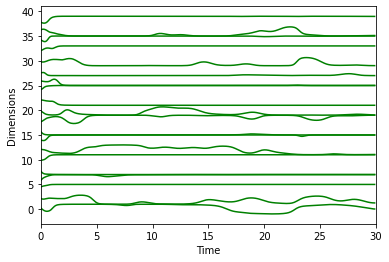

In [7]:
esn1 = EchoStateNet(num_input=1, num_hidden=500, num_output=20, dt=dt, g=1.8)
rs, ys = esn1.simulate(xs)
targets = rs[:, 0: esn1.num_output]  # This will be the training data for the trained ESN
plt.plot(times, targets + 2 * np.arange(0, esn1.num_output), 'g')
plt.xlim((0, T))
plt.ylabel('Dimensions')
plt.xlabel('Time')
plt.show()

Un-trained ESN.

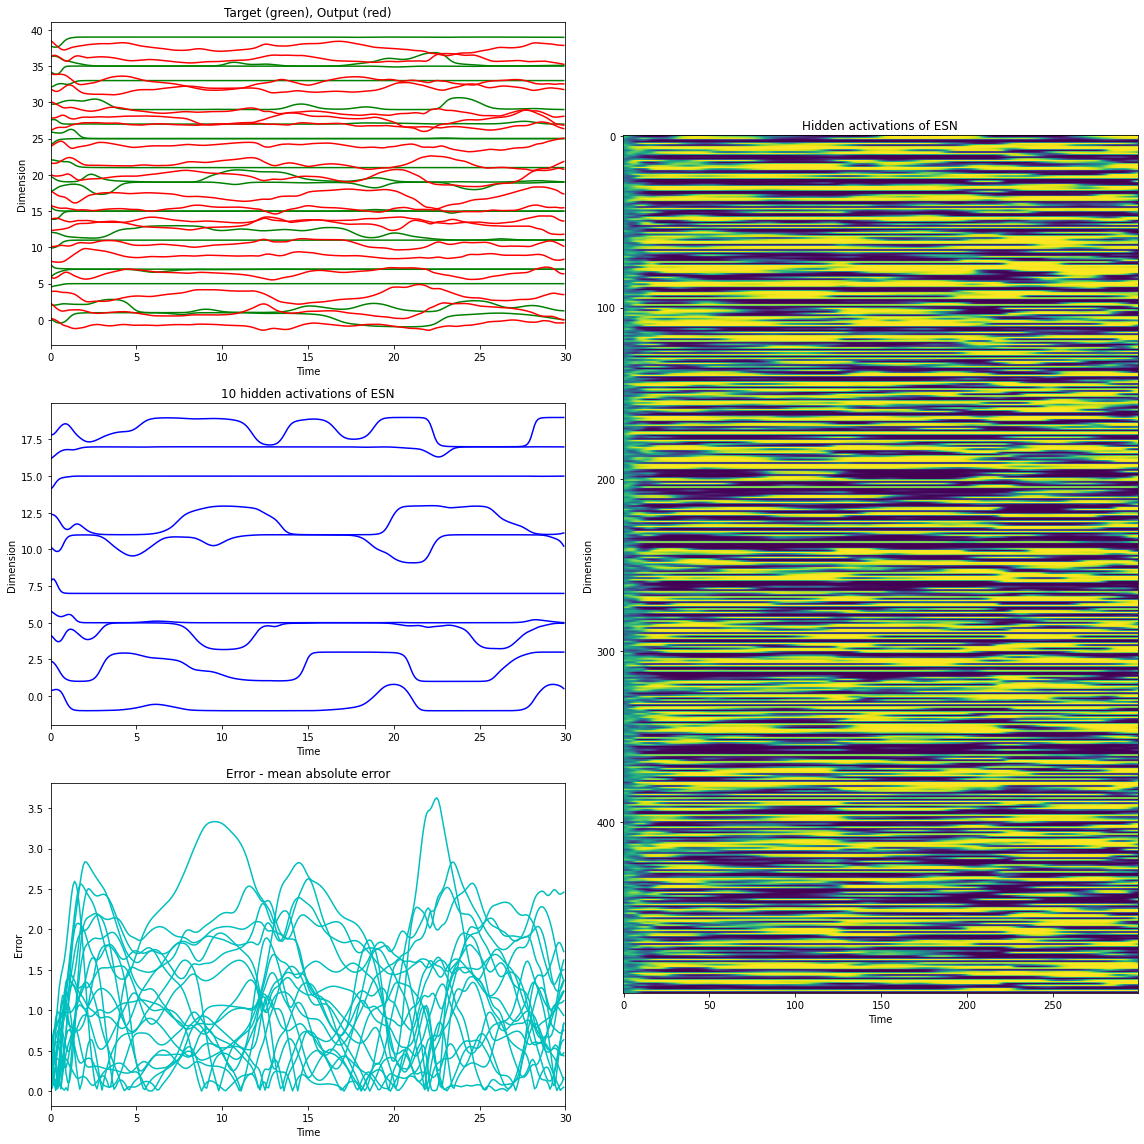

In [8]:
esn2 = EchoStateNet(num_input=1, num_hidden=500, num_output=20, dt=dt, g=1.5)
rs, ys = esn2.simulate(xs)  # the untrained ESN
print_force(times, rates=rs, outs=ys, targets=targets, duration=T, ntoplot=10)

Trained ESN.

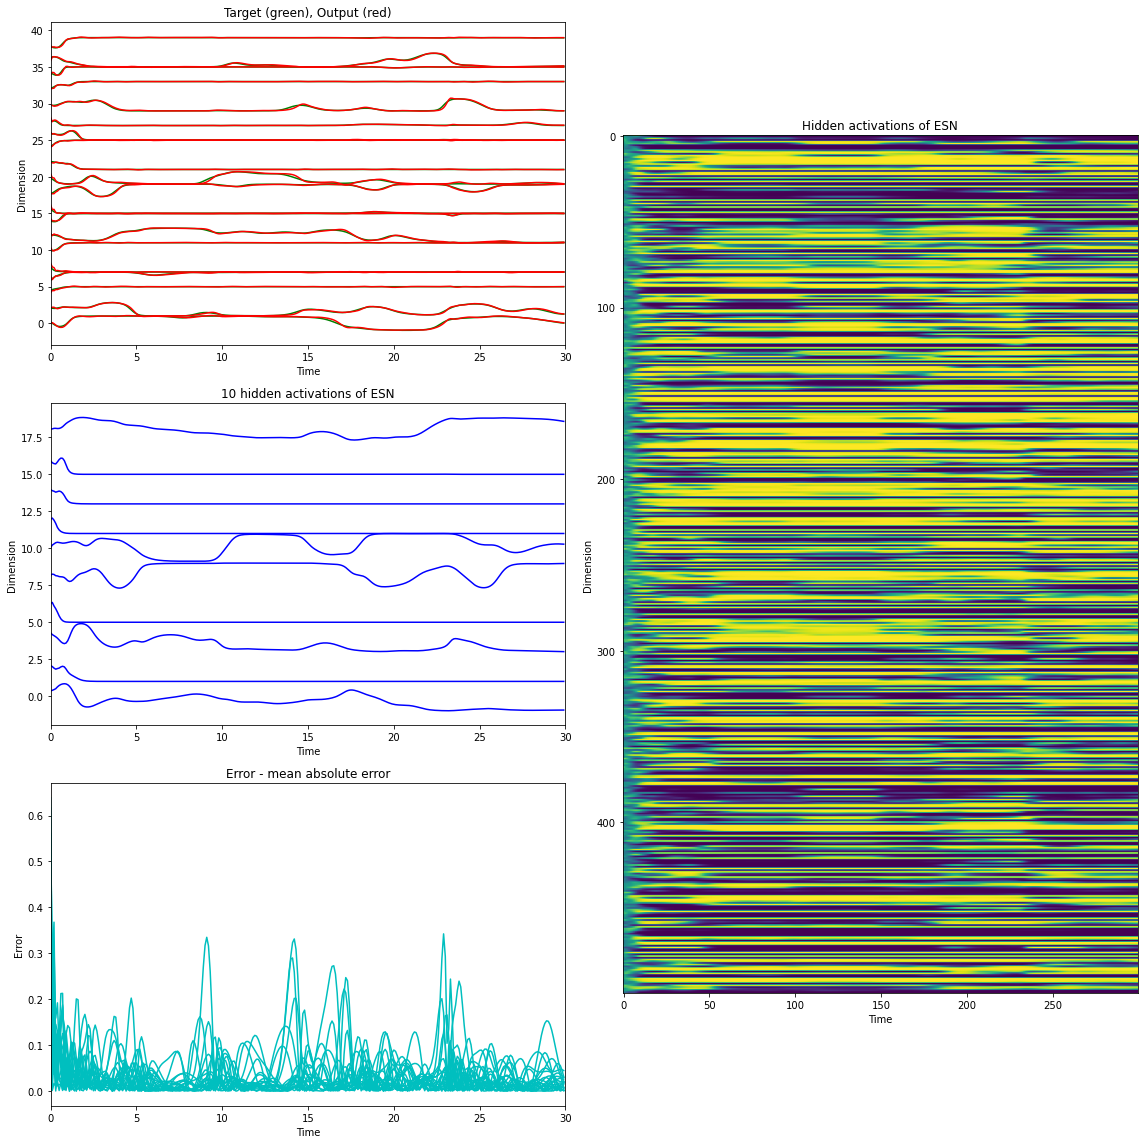

In [9]:
esn3 = EchoStateNet(num_input=1, num_hidden=500, num_output=20, dt=dt, g=1.5, alpha=1.)
rs, ys = esn3.train(xs=xs, targets=targets)  # train once
print_force(times, rates=rs, outs=ys, targets=targets, duration=T, ntoplot=10)

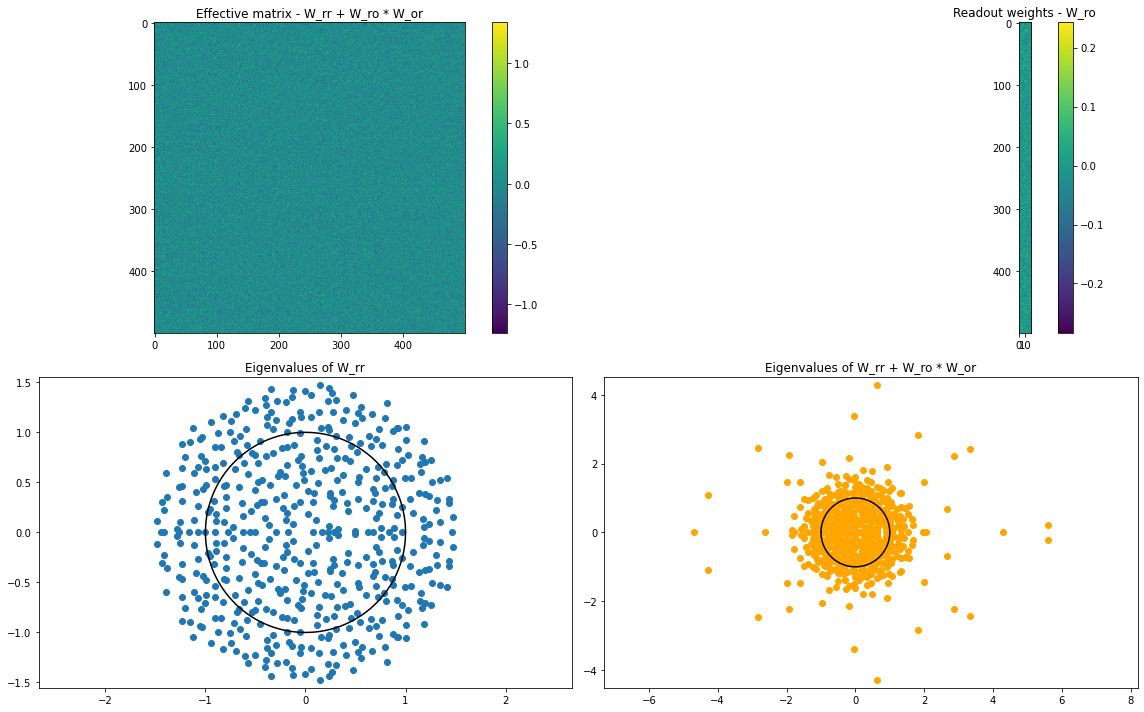

In [10]:
plot_params(esn3)